In [1]:
import jax
from importlib import resources
import jacscanomaly
import numpy as np
import jacscanomaly.parallax as parallax
import jax.numpy as jnp
import matplotlib.pyplot as plt

import MulensModel as mm
import VBMicrolensing
VBM = VBMicrolensing.VBMicrolensing()

ra = 263.4875417
dec = -29.9293472

In [2]:
# ============================================================
# Optional microlensing trajectory
# ============================================================
def microlensing_trajectory_with_parallax(t, t0, tE, u0, piEN, piEE, P):
    tau0  = (t - t0) / tE
    beta0 = jnp.full_like(t, u0)
    d_tau, d_beta = parallax.earth_orbital_parallax_offsets_jit(t, piEN, piEE, P)
    return tau0 + d_tau, beta0 + d_beta

microlensing_trajectory_with_parallax_jit = jax.jit(
    microlensing_trajectory_with_parallax
)

def pspl_A(u):
    return (u**2 + 2) / (u * np.sqrt(u**2 + 4))


In [3]:
def load_earth_orbital_parallax_array():
    p = resources.files("jacscanomaly.data").joinpath("earth_orbital_parallax_table.txt")
    with p.open("r") as f:
        return np.genfromtxt(
            f,
            skip_header=59, skip_footer=60
        )

eph = parallax.HeliocentricEphemeris.from_horizons_table(load_earth_orbital_parallax_array())

t0 = 2460000.
tE = 100.
u0 = 0.1
tref = t0
piEN, piEE = 0.1, 0.1

t_range = [t0 - 5.0 * tE, t0 + 5.0 * tE]
t = np.linspace(t_range[0],t_range[1],1000)

P = parallax.EarthOrbitalParallaxProjector(eph, ra, dec, tref)
t_j = jnp.asarray(t, dtype=eph.t.dtype)
tau, beta = microlensing_trajectory_with_parallax_jit(
    t_j, t0, tE, u0, piEN, piEE, P
)

u = np.sqrt(tau**2 + beta**2)
mag = pspl_A(u)

In [4]:
pr_vbm = [u0, np.log(tE), t0-2450000, piEN, piEE]
VBM.SetObjectCoordinates("17:33:57.01 -29:55:45.65")
mag_vbm, tau_vbm, beta_vbm = VBM.PSPLLightCurveParallax(pr_vbm, t-2450000)
mag_vbm, tau_vbm, beta_vbm = map(np.asarray,[mag_vbm, tau_vbm, beta_vbm])
tau_vbm, beta_vbm = map(lambda x : -x, [tau_vbm, beta_vbm]) #なぜかvbmは符号を逆にして返す。

In [5]:
params_mm = dict()
params_mm['t_0'] = t0
params_mm['t_0_par'] = t0
params_mm['u_0'] = u0
params_mm['t_E'] = tE
params_mm['pi_E_N'] = piEN
params_mm['pi_E_E'] = piEE
mm_model = mm.Model(params_mm, coords="17:33:57.01 -29:55:45.65")
mm_traj = mm_model.get_trajectory(t)
tau_mm, beta_mm = mm_traj.x, mm_traj.y
mag_mm = mm_model.get_magnification(t)

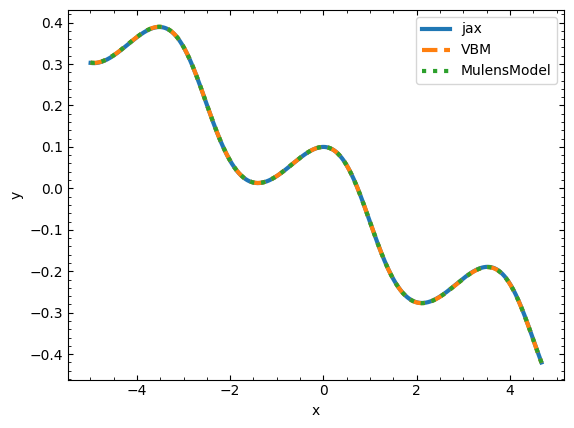

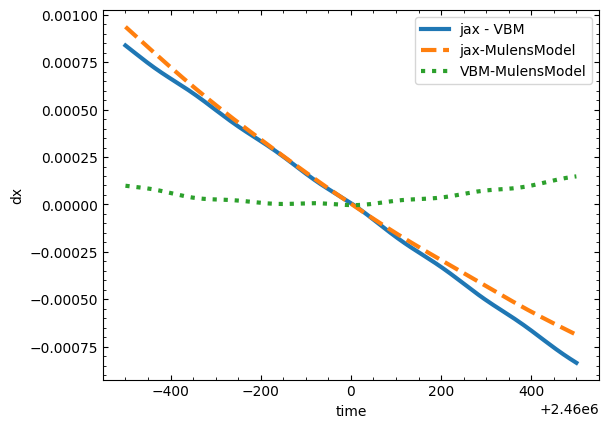

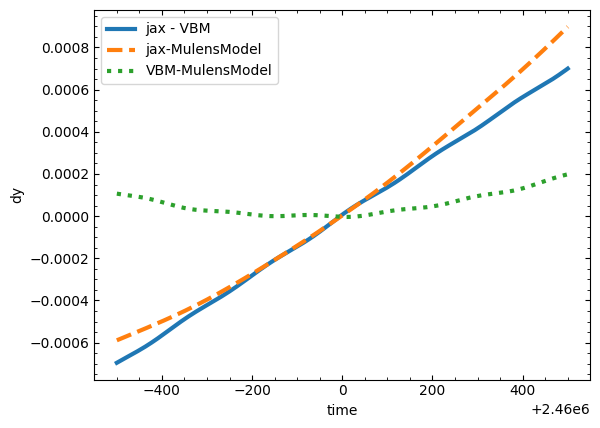

In [6]:
plt.plot(tau,beta,lw=3,label="jax")
plt.plot(tau_mm,beta_mm,"--",lw=3,label="VBM")
plt.plot(tau_vbm,beta_vbm,":",lw=3,label="MulensModel")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

plt.plot(t,tau-tau_vbm,lw=3,label="jax - VBM")
plt.plot(t,tau-tau_mm,"--",lw=3,label="jax-MulensModel")
plt.plot(t,tau_vbm-tau_mm,":",lw=3,label="VBM-MulensModel")
plt.legend()
plt.xlabel("time")
plt.ylabel("dx")
plt.show()

plt.plot(t,beta-beta_vbm,lw=3,label="jax - VBM")
plt.plot(t,beta-beta_mm,"--",lw=3,label="jax-MulensModel")
plt.plot(t,beta_vbm-beta_mm,":",lw=3,label="VBM-MulensModel")
plt.legend()
plt.xlabel("time")
plt.ylabel("dy")
plt.show()

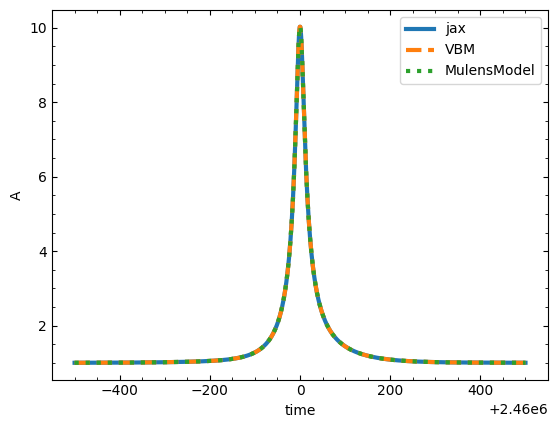

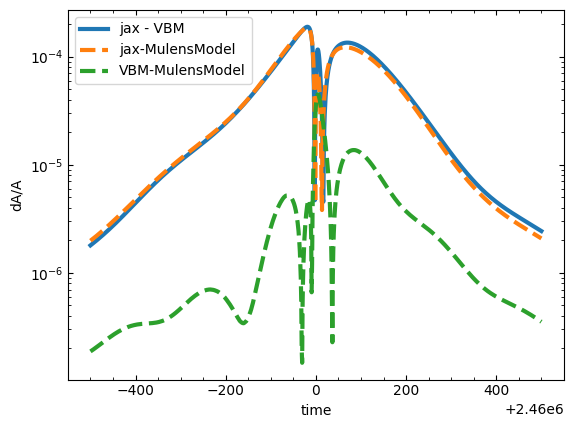

In [7]:
plt.plot(t,mag,lw=3,label="jax")
plt.plot(t,mag_mm,"--",lw=3,label="VBM")
plt.plot(t,mag_vbm,":",lw=3,label="MulensModel")
plt.legend()
plt.xlabel("time")
plt.ylabel("A")
plt.show()

plt.plot(t,np.abs(mag-mag_vbm)/mag,lw=3,label="jax - VBM")
plt.plot(t,np.abs(mag-mag_mm)/mag,"--",lw=3,label="jax-MulensModel")
plt.plot(t,np.abs(mag_vbm-mag_mm)/mag_vbm,"--",lw=3,label="VBM-MulensModel")
plt.legend()
plt.xlabel("time")
plt.ylabel("dA/A")
plt.yscale("log")
plt.show()